# Data Structures & Signal Processing

## Part I: Spike sorting raw electrophysiology data
When you record extracellular electrophysiology data, one of the first data processing steps is figuring out which action potentials (or "spikes") came from which neurons. The process of doing this is called **spike sorting**.

Below, we'll work with [this dataset](https://dandiarchive.org/dandiset/000053/0.210819.0345) from [Lisa Giocomo's lab at Stanford](https://giocomolab.weebly.com/) to demonstrate the simplest form of spike sorting: thresholding, followed by feature extraction.

### Step 1. Inspect the Data

First, we need to find the correct URL for the dataset on the NWB's Amazon S3 storage system. There is a tool to do so within the dandiapi, which we'll use below to get the URL for one session within the dataset.

In [ ]:
from dandi.dandiapi import DandiAPIClient

dandiset_id = '000053' # giocomo data
filepath = 'sub-npI5/sub-npI5_ses-20190414_behavior+ecephys.nwb' 

with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)
    
print(s3_path)

### Step 2: Stream Data

Now that we have this path, we can stream the data rather than downloading it. Below, we'll print some useful information about this experiment. We will also access a dataset we haven't interacted with yet: [`ElectricalSeries`](https://pynwb.readthedocs.io/en/stable/tutorials/domain/ecephys.html). As the name suggests, this group contains raw electrophysiology data -- exactly what we need to sort! We will assign a portion of this to an object called `ephys_data`.

<mark>**Note**: The cell below will take about a minute to run, depending on the speed of your internet connection.</mark>

In [ ]:
try:
    from pynwb import NWBHDF5IO

    with NWBHDF5IO(s3_path, mode='r', load_namespaces=True, driver='ros3') as io:
        nwbfile = io.read()
        
        # save sampling freq and ephys data with file open
        sampling_freq = nwbfile.acquisition['ElectricalSeries'].rate # get the sampling frequency in Hz
        ephys_data = (nwbfile.acquisition['ElectricalSeries'].data[:3000000, 99])*nwbfile.acquisition['ElectricalSeries'].conversion
        units_df = nwbfile.units.to_dataframe()
        
        print(f"Data shape: {nwbfile.acquisition['ElectricalSeries'].data.shape}")
        
except ValueError:
    print('Environment is not configured for pynwb.')
    ephys_data = []
    sampling_freq = 400

### Step 3. Access Information within the NWB File Hierarchy

One of the first steps when working with a new dataset is to figure out what is in the dataset, and where. Each NWB file is composed of various groups, which either contain attributes of our file (**metadata**) or the data itself.

> **Metadata** is a common term to describe all of the information about an experiment. This could include everything from when the experiment was conducted, the ID of the subject (animal, human, goblin, etc.), the equipment details, etc. In essence, the metadata provides the context of the experiment. This is one of the first things you should review when you’re encountering a new dataset.

Here is the structure of a typical NWB file:

![](https://nwb4edu.github.io/_images/NWB_file_structure.png)

In order to see which groups are in our file, we can use the `fields` attribute to return a dictionary containing the the Groups of our NWB file. The dictionary **keys** are the various groups within the file which we will use to access the data we're ultimately interested in.

> Need a refresher on dictionaries? Consider working through the free [Codecademy Python 3 lesson](https://www.codecademy.com/enrolled/courses/learn-python-3), or check the other resources on the [Data Science in Python](https://nwb4edu.github.io/Data_Science_In_Python/Introduction.html) page.

In [ ]:
# Get the Groups for the nwb file 
nwb_fields = nwbfile.fields
print(nwb_fields.keys())

#### Experiment Metadata

Let's first pull out some metadata for the experiment we downloaded.

Each NWB file will have information on where the experiment was conducted, which lab conducted the experiment, as well as a description of the experiment. This information can be accessed using `institution`, `lab`, and `experiment_description`, attributes on our nwb_file, respectively.

In [ ]:
# Look for attributes of file
nwbfile.

As you might have noticed at this point, we can access datasets from each group in our nwb_file with the following syntax: `nwb_file.GROUPNAME`, just as we would typically access an attribute of object in Python. Below we will demonstrate some of the most useful groups within an NWB object. 

#### Acquisition 

The `acquisition` group contains datasets of acquisition data, mainly `TimeSeries` objects belonging to this NWBFile. 

Before we dive into spike sorting, let's take a look at the data. Below, we'll import a couple additional packages, generate a list of timestamps, and plot it.

>**Note**: Need a reminder on how some of the packages or functions below work? Look through the [NumPy](https://nwb4edu.github.io/Chapter_02/NumPy.html) and [Matplotlib](https://nwb4edu.github.io/Chapter_02/Matplotlib.html) review pages.

In [ ]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt

# generate a vector of timestamps
timestamps = np.arange(0, len(ephys_data)) * (1.0 / sampling_freq)

fig,ax = plt.subplots(1,1,figsize=(15,3))
plt.plot(timestamps,ephys_data)
plt.ylabel('Voltage (V)')
plt.xlabel('Seconds (s)')
#plt.xlim(1.053,1.055)
plt.show()

In the data above, there are clear places where the data "spikes". These are extracellularly recorded action potentials!

### Step 4. Spike Detection

One of the most straightforward ways to spike sort is to simply detect these using a threshold. Whenever the signal passes this threshold, we'll clip that out. We could determine a reasonable threshold by eye, but we'll do this mathematically instead, using the standard deviation of the signal. When the signal is five times the standard deviation, that's enough signal to noise that it's likely to be an action potential. We'll calculate that below.

In [ ]:
noise_std = np.std(ephys_data)
recommended_threshold = -5 * noise_std
print('Noise Estimate by Standard Deviation: ', noise_std)
print('Recommended Spike Threshold         : ', recommended_threshold)

Our spike detector needs to take into account that a spike typically comprises multiple samples, so we can't simply take each sample that exceeds the threshold as an individual spike detection. Instead, we'll define a *dead time*: whenever we detect a spike, the next few samples within the dead time won't trigger a spike detection by themselves.

In order to generate a more precise idea of where each spike is we will also search for the minimum in each spike by lookiing through the signal for a short period of time after the threshold crossing. The time of this minimum will be the timestamp for each spike.

Below, we'll define three helper functions to accomplish this detection strategy:

In [ ]:
def detect_threshold_crossings(signal, fs, threshold, dead_time):
    """
    Detect threshold crossings in a signal with dead time and return them as an array
    
    The signal transitions from a sample above the threshold to a sample below the threshold for a detection and
    the last detection has to be more than dead_time apart from the current one.
    
    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold: The threshold for the signal
    :param dead_time: The dead time in seconds. 
    """
    dead_time_idx = dead_time * fs
    threshold_crossings = np.diff((signal <= threshold).astype(int) > 0).nonzero()[0]
    distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    while not np.all(distance_sufficient):
        # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    return threshold_crossings

def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index
    
    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index 
    :param max_samples_to_search: The number of samples to search for a minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx

def align_to_minimum(signal, fs, threshold_crossings, search_range):
    """
    Returns the index of the next negative spike peak for all threshold crossings
    
    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold_crossings: The array of indices where the signal crossed the detection threshold
    :param search_range: The maximum duration in seconds to search for the minimum after each crossing
    """
    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)

Now, we can use those functions to detect threshold crossings. We'll then plot our original signal with the detected spikes marked.

In [ ]:
crossings = detect_threshold_crossings(ephys_data, sampling_freq, recommended_threshold, 0.003) # dead time of 3 ms
spks = align_to_minimum(ephys_data, sampling_freq, crossings, 0.002) # search range 2 ms

fig,ax = plt.subplots(1,1,figsize=(20,5))
plt.plot(ephys_data)
plt.xlabel('Samples')
plt.ylabel('Voltage (uV)')
plt.plot(spks,[recommended_threshold]*spks.shape[0], 'ro', ms=2)
ax.ticklabel_format(useOffset=False, style='plain')
#plt.xlim([0,len(ephys_data)])
plt.show()

Finally, we can cut out the waveforms from these detected spikes so that we can look at their shape. To do so, we will cut out a portion of the signal around each spike. Spikes too close to the start or end of the signal that a full cutout is not possible are ignored. 

The location and shape of a waveform is one of the main pieces of evidence to show that the waveform was recorded from a cell. This will help us determine whether or not there is just one or more neurons recorded on this channel. 

Below, we will define two helper functions: one to extract the waveforms, and one to plot them.

In [ ]:
def extract_waveforms(signal, fs, spikes_idx, pre, post):
    """
    Extract spike waveforms as signal cutouts around each spike index as a spikes x samples numpy array
    
    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param spikes_idx: The sample index of all spikes as a 1-dim numpy array
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    """
    cutouts = []
    pre_idx = int(pre * fs)
    post_idx = int(post * fs)
    for index in spikes_idx:
        if index-pre_idx >= 0 and index+post_idx <= signal.shape[0]:
            cutout = signal[(index-pre_idx):(index+post_idx)]
            cutouts.append(cutout)
    return np.stack(cutouts)

def plot_waveforms(cutouts, fs, pre, post, n=100):
    """
    Plot an overlay of spike cutouts
    
    :param cutouts: A spikes x samples array of cutouts
    :param fs: The sampling frequency in Hz
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    :param n: The number of cutouts to plot, or None to plot all. Default: 100
    """
    if n is None:
        n = cutouts.shape[0]
    n = min(n, cutouts.shape[0])
    time_in_us = np.arange(-pre, post, 1/fs)
    plt.figure(figsize=(12,6))
    
    for i in range(n):
        plt.plot(time_in_us, cutouts[i,], color='k', linewidth=1, alpha=0.3)
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)' )

    plt.show()

Now, let's extract & plot the waveforms.

In [ ]:
try:
    pre = 0.001 # 1 ms
    post= 0.002 # 2 ms
    waveforms = extract_waveforms(ephys_data, sampling_freq, spks, pre, post)
    plot_waveforms(waveforms, sampling_freq, pre, post, n=500)
    min_voltage = np.amin(waveforms, axis=1)
    max_voltage = np.amax(waveforms, axis=1)

except ValueError:
    print('No data loaded.')
    min_voltage, max_voltage = 0,0

Looking at the plot above, would you say there is just one waveform here, or multiple?

### Step 5. Feature Extraction

Indeed, it looks like there might be two -- one that is very high amplitude, and another that is lower amplitude. We can use **feature extraction** to investigate our waveforms. Below, we'll plot the minimum and maximum voltages in the recorded waveforms to see if there are distinct clusters of waveforms.

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(min_voltage, max_voltage,'.')
plt.xlabel('Minimum Voltage (V)')
plt.ylabel('Maximum Voltage (V)')
plt.title('Min/Max Spike Voltages')

plt.show()

Looking at the scatterplot above, would you say there is more than one cluster of waveforms?

For these two units, separating by minimum & maximum voltage actually works fairly well! However, many action potentials have shapes that cannot be easily summarized by one feature such as the minimum voltage. For this, a more general feature extraction method such as principal component analysis (PCA) is typically used.

## Part I summary
In this part, we've looked closely at just 100 seconds of one channel in a 384-channel recording. You can imagine how long spike sorting would take if we needed to do this for *all* of the data. Thankfully, there are more automated spikesorting tools which enable researchers to automatically sort their data, with just a little bit of sorting by hand. In the next notebook, we'll work with data that has already been sorted for us. The resulting data simply has spike times for each sorted neuron (or "unit") -- the moments in the experiment where a spike happened. This is the most common format for data sharing of extracellularly recorded data, since it's much more concise, and the hard work of spike sorting has already happened.

## Part II: Working with processed data

As a data scientist, most of the time you'll be working with data that has already been sorted. When we first read in the data above, we saved this as a dataframe using:
```
units_df = nwbfile.units.to_dataframe()
```
### Step 1. Inspect data

Let's look at the dataframe first.

In [ ]:
# Inspect dataframe


The `spike_times` column contains the times at which the recorded neuron fired an actiion potential. Each neuron has a list of spike times for their `spike_times` column. 

In [ ]:
# Return the first 10 spike times for your neuron of choice
unit_id = 1
first_10 = ...

### Step 2: Create raster plot
A **spike raster plot** can be created using the function `plt.eventplot`. A spike raster plot displays the spiking of neurons over time. In a raster plot, each row corresponds to a different neuron or a different trial, and the x-axis represents the time. Each small vertical line in the plot represents the spiking of a neuron. Spike raster plots are useful as they reveal firing rate correlations between groups of neurons. For more information on `plt.eventplot` please visit the <a href = 'https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.eventplot.html'> matplotlib documentation</a>. 

Below, we'll create a function called `plot_raster()` that creates a raster plot from the `spike_times` column in `units`. `plot_raster()` takes the following arguments:

- `unit_df`: dataframe containing spike time data
- `neuron_start`: index of first neuron of interest 
- `neuron_end`: index of last neuron of interest
- `start_time`: start time for desired time interval 
- `end_time`: end time for desired time interval

In [ ]:
# Function for creating raster plots for Units group in NWB file 
def plot_raster(units_df,neuron_start,neuron_end,start_time,end_time):
    
    # Select the data 
    neural_data = units_df['spike_times'][neuron_start:neuron_end]
    
    # Calculate # of neurons
    num_neurons = neuron_end - neuron_start
    
    #Generate colors
    colors1 = ['C{}'.format(i) for i in range(num_neurons)] 
    
    # Plot our raster plot 
    plt.eventplot(neural_data,colors=colors1)

    # Set our axis limits to only include points in our data
    plt.xlim([start_time,end_time])
    
    # Label our figure 
    plt.title('Spike raster plot')
    plt.ylabel('Neuron #')
    plt.xlabel('Time (s)')
    plt.yticks(np.arange(0,num_neurons))

plot_raster(units_df, neuron_start = 2, neuron_end = 11, start_time = 330, end_time = 333)

# Show our plot 
plt.show()

The plot above is only contains neural spikes from a 3 second time interval. While there are many spikes to consider in this one graph, each neuron has much more than 3 seconds worth of spike recordings!

### Step 3: Bin Firing Rates 

Raster plots are great for seeing individual neural spikes, but difficult to see the overall firing rates of the units. To get a better sense of the overall firing rates of our units, we can bin our spikes into time bins of 1 second:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_firing_rates(spike_times, start_time=None, end_time=None):
    """
    Plots raster plot of spike times for each neuron and returns binned spike times.
    
    Parameters:
        spike_times (DataFrame): Pandas series with spike times for each neuron (needs to be > 1 neuron)
        start_time (float or None): Start time for plotting and binning.
        end_time (float or None): End time for plotting and binning.
        
    Returns:
        binned_spike_times (ndarray): Array of binned spike times.
    """
    
    # Set start_time and end_time if not provided
    if start_time is None:
        start_time = np.min(spike_times)
    if end_time is None:
        end_time = np.max(spike_times)
    
    # Create bins
    bin_edges = np.arange(start_time, end_time + 1, 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Initialize array to store binned spike times
    binned_spike_times = np.zeros((len(spike_times), len(bin_centers)))
    
    # Bin spike times
    for i, neuron_spikes in enumerate(spike_times):
        binned_spike_times[i], _ = np.histogram(neuron_spikes, bins=bin_edges)
    
    plt.plot(binned_spike_times.T)
        
    plt.xlabel('Time (s)')
    plt.ylabel('Firing Rate (Hz)')
    plt.show()
    
    return binned_spike_times


Let's use the function we just created to plot the first 10 neurons, for seconds 300-500.

In [ ]:
binned_spikes = plot_firing_rates(units_df['spike_times'].iloc[:10],300,500)
binned_spikes

### Step 4: Look for spike correlations

Now that we have binned spike counts, we can look for spike count correlations.

<div class="alert alert-success">

**Task**:
    
1. Using `signal.correlate()`, compute the cross correlation of any two neurons in `binned_spikes`.
2. Plot the correlation versus the time shifts.
3. Identify two cells that are clearly correlated in time.
    
</div>

In [ ]:
from scipy import signal

# Compute cross correlogram
xcorr = ...

# Compute time steps
time_shift = np.arange(-len(xcorr)/2,len(xcorr)/2,1)

# Plot

## Bonus Code: The Nyquist frequency!
Recall from lecture that signals can only be represented properly if one is sampling the signal more than twice as fast as the fastest frequency component in the signal itself. Otherwise, our sampled signal will be distorted. Below, we'll plot a set of graphs with different sampling frequencies to demonstrate this point.

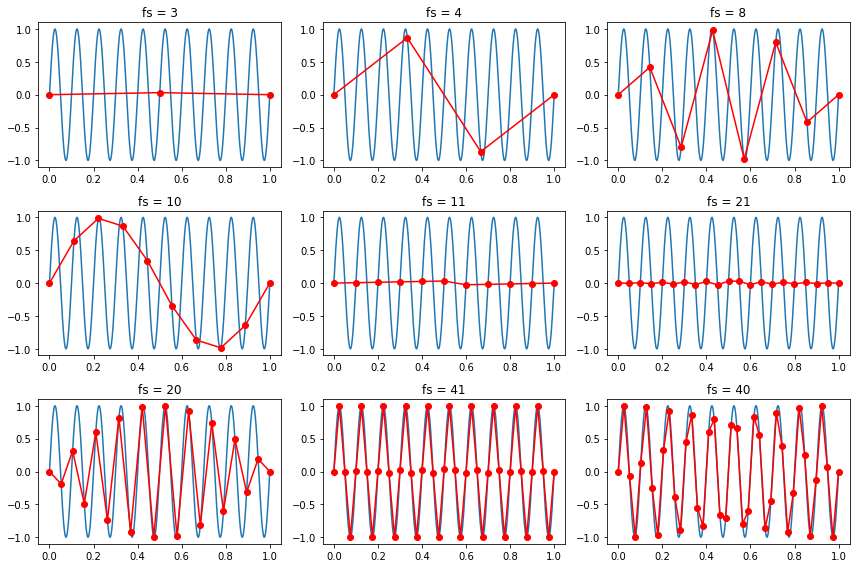

In [3]:
import numpy as np
import matplotlib.pyplot as plt

realSampling = 1000 # Define the real frequency
t = np.linspace(0,1,realSampling) # Define a time base with the same resolution
signalFrequency = 10 # Define the signal frequency
sampling_freq_list = [3, 4, 8, 10, 11, 21, 20, 41, 40] # Define nine different sampling rates
sig = np.sin(2*np.pi*signalFrequency*t)# Define a sine wave at our signal frequency

# Plot these graphs
fig, ax = plt.subplots(figsize=(12, 8))

for ii,sampleRate in enumerate(sampling_freq_list):
    ax = plt.subplot(3,3,ii+1) # Change the subplot (best way with a grid)
    ax.plot(t,sig) #  Plot the "real" signal over time
    sampledSignal = np.rint(np.linspace(0, len(t)-1, sampleRate)).astype(int) # Calculate the sampled signal
    
    # Plot sampled signal over the same time base, but in red
    q = ax.plot(t[sampledSignal],sig[sampledSignal],c='r',marker='o',markersize=6); 
    plt.tight_layout() # Fix the layout
    plt.title('fs = '+str(sampleRate)) 

## Notes & resources
This notebook borrows inspiration and code from [this tutorial](https://github.com/multichannelsystems/McsPyDataTools/blob/master/McsPyDataTools/docs/McsPy-Tutorial_DataAnalysis.ipynb) which is protected under a copyright: Copyright (c) 2018, Multi Channel Systems MCS GmbH
All rights reserved.